In [1]:
import os
import numpy as np
import pandas as pd
import scipy.stats as st
import pickle as pkl
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import theano
import theano.tensor as T
from sklearn.model_selection import train_test_split

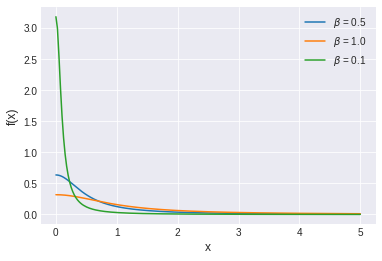

In [2]:
# half cauchy
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
plt.style.use('seaborn-darkgrid')
x = np.linspace(0, 5, 200)
for b in [0.5, 1.0, 0.1]:
    pdf = st.cauchy.pdf(x, scale=b)
    plt.plot(x, pdf, label=r'$\beta$ = {}'.format(b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

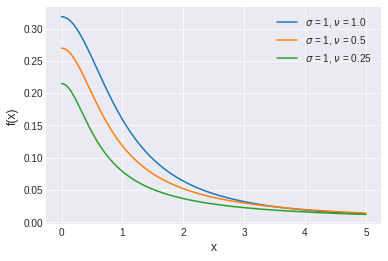

In [3]:
#half student t
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
plt.style.use('seaborn-darkgrid')
x = np.linspace(0, 5, 200)
sigmas = [1, 1, 1]
nus = [1., 0.5, 0.25]
for sigma, nu in zip(sigmas, nus):
    pdf = st.t.pdf(x, df=nu, loc=0, scale=sigma)
    plt.plot(x, pdf, label=r'$\sigma$ = {}, $\nu$ = {}'.format(sigma, nu))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

In [4]:
# read data
fp = os.path.abspath('model_set.csv')
raw_df = pd.read_csv(fp)

FileNotFoundError: [Errno 2] No such file or directory: '/home/samvoisin/Projects/PythonProjects/kaggle/bayesian-hp/notebooks/model_set.csv'

In [ ]:
# data transforms
raw_df["LogSalePrice"] = np.log(raw_df.SalePrice)
raw_df.CentralAir = [1 if i == "Y" else 0 for i in raw_df.CentralAir]
raw_df.YrSold = raw_df.YrSold - raw_df.YrSold.min()  # years from 2006
raw_df.YearBuilt = raw_df.YearBuilt - raw_df.YearBuilt.min()  # years from 1872
Neighborhoods = raw_df.Neighborhood.unique()
NbdLookup = dict(zip(Neighborhoods, range(Neighborhoods.size)))
raw_df["NeighborhoodCode"] = raw_df.Neighborhood.replace(NbdLookup)

# drop unecessary cols
d_cols = ["Utilities"]
raw_df.drop(columns=d_cols, inplace=True)

In [ ]:
### data preparation and formatting ###

# design matix
covariates = ("1stFlrSF", "LotArea")
y = raw_df.LogSalePrice
X = raw_df.loc[:, covariates]
X_nbd = raw_df.loc[:, "NeighborhoodCode"]
n_nbd = Neighborhoods.size
n, p = X.shape

# train-test split
train_idx, test_idx = train_test_split(range(n),
                                       test_size=0.2,
                                       random_state=1)
X_train = X.iloc[train_idx, :].reset_index(drop=True)
X_nbd_train = X_nbd.iloc[train_idx].reset_index(drop=True)
X_test = X.iloc[test_idx, :].reset_index(drop=True)
X_nbd_test = X_nbd.iloc[test_idx].reset_index(drop=True)
y_train = y.iloc[train_idx].reset_index(drop=True)
y_test = y.iloc[test_idx].reset_index(drop=True)

In [ ]:
X_train.shape

In [ ]:
X_nbd_train.shape

In [ ]:
hp_model = pm.Model()

In [ ]:
Ip_mat = np.eye(p)
zp_vec = np.zeros(p)

In [ ]:
# specify model and perform sampling
with hp_model:
    X_train_data = pm.Data("X_train_data", X_train)
    nbd_idx = pm.Data("nbd_idx", X_nbd_train)
    y_train_data = pm.Data("y_train_data", y_train)
    # hyper priors
    chol, corr, stds = pm.LKJCholeskyCov("Omega", n=p, eta=1.,
                                         sd_dist=pm.HalfStudentT.dist(sigma=0.5,
                                                                      nu=1.),
                                         compute_corr=True)
    cov = pm.Deterministic("cov", chol.dot(chol.T))
    tau_alpha = pm.HalfStudentT("tau_alpha", sigma=0.5, nu=1.)
    alpha = pm.Normal("alpha", mu=12., sigma=0.5)
    # priors
    alpha_nbd = pm.Normal("alpha_nbd", mu=alpha, sigma=tau_alpha, shape=(n_nbd,))
    beta_uc = pm.MvNormal("beta_uc", mu=zp_vec, cov=Ip_mat, shape=(p,))
    beta = pm.Deterministic("beta", cov.dot(beta_uc))
    sigma = pm.HalfStudentT("sigma", sigma=0.5, nu=1.)
    # likelihood
    Ey_x = T.add(alpha_nbd[nbd_idx], X_train_data.dot(beta))  # E[Y|X]
    y_obs = pm.Normal("y_obs", mu=Ey_x, sigma=sigma, observed=y_train_data)

In [ ]:
pm.model_to_graphviz(hp_model)

In [ ]:
# sampling
with hp_model:
    posterior = pm.sample(draws=50, tune=200, cores=2,
                          init="advi+adapt_diag",
                          target_accept=0.95,
                          return_inferencedata=False)
    posterior_predictive = pm.fast_sample_posterior_predictive(posterior)

In [ ]:
# https://bpostance.github.io/posts/pymc3-predictions/
# example of out-of-sample predictions
with bglm:
    pm.set_data({"pred": testx.T})
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["y"], samples=600)
    model_preds = posterior_predictive["y"]


In [ ]:
t = pd.DataFrame(posterior_predictive["y_obs"].T)
t.columns = [f"sample_{i}" for i in range(t.shape[1])]
t.to_csv("./posterior_pred_samps.csv", index=False)

In [ ]:
t.to_csv("./posterior_pred_samps.csv", index=False)

In [ ]:
posterior_predictive["y_obs"].shape

pm.save_trace(trace=posterior) DONT RUN THIS UNLESS YOURE SURE

In [ ]:
posterior.get_sampler_stats()

In [ ]:
pm.load_trace('.pymc_1.trace')

In [ ]:
posterior